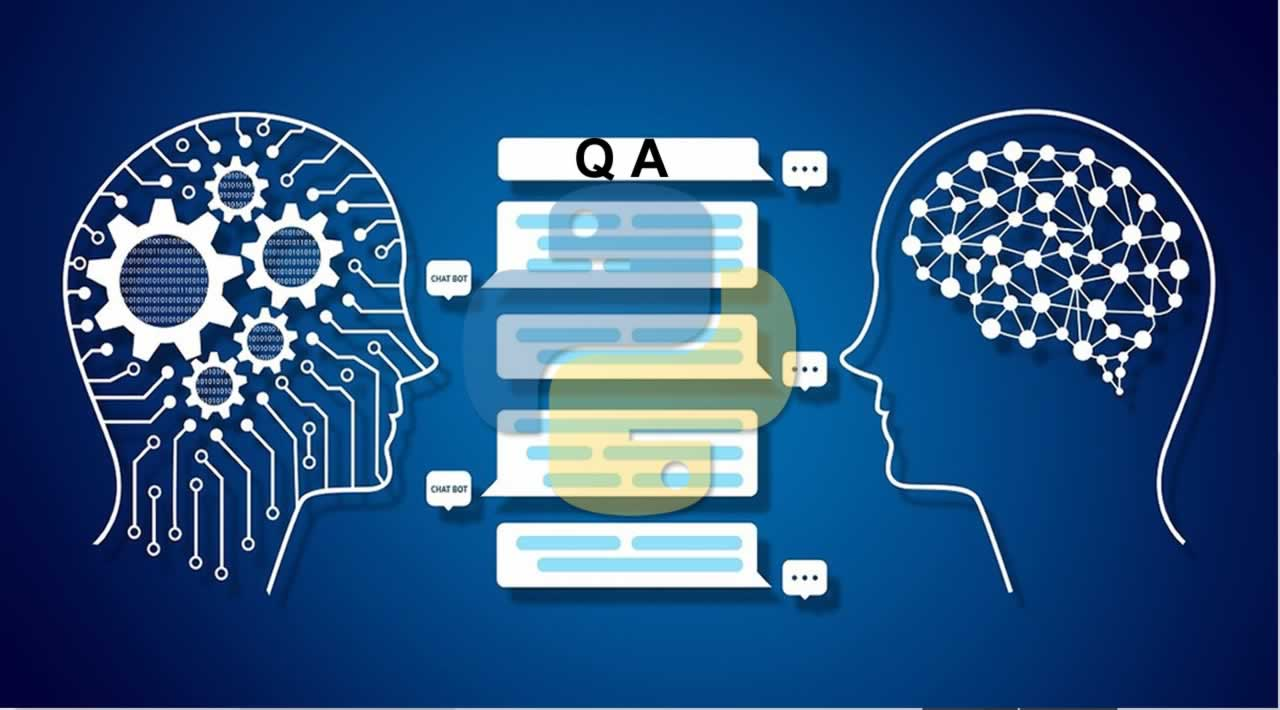



# Challenge - Wikipedia Question Answering
### **Objective**
“Why is the sky blue?”

This is the type of questions an open-domain question answering (QA) system should be able to respond to. QA systems emulate how people look for information, by reading the web to return answers to common questions. Machine learning can be used to improve the accuracy of those answers.

Existing natural language models have been focused on extracting answers from a short paragraph rather than reading an entire page of content for proper context. As a result, the responses can be complicated or lengthy. A good answer will be both succinct and relevant.

In this challenge, our goal is to predict short and long answer responses to real questions about Wikipedia articles. The dataset is provided by [Google's Natural Questions](https://ai.google.com/research/NaturalQuestions/dataset) and available [here](https://www.kaggle.com/c/tensorflow2-question-answering/data).

To better understand the data and the 2 types of answers to predict, for the example of this question: *"When did the watts riot start and end?"*
a long answer would be: *"The Watts riots, sometimes referred to as the Watts Rebellion or Watts Uprising, took place in the Watts neighborhood and its surrounding areas of Los Angeles from August 11 to 16, 1965."*, whilst a short one would be: *"August 11 to 16, 1965."*



## **Method**

From a question, we will predict both types of answers, using BERT based models. More precisely:

- We will fine tune Bert for binary classification in order to predict long answers, i.e. the paragraph from the Wikipedia webpage containing the answer to the given question
- We will fine tune Bert for question-answering in order to predict short answers

In [ ]:
# Install simpletransformers library
!pip install simpletransformers

     |████████████████████████████████| 215kB 5.7MB/s 
     |████████████████████████████████| 1.2MB 54.3MB/s 
     |████████████████████████████████| 225kB 57.5MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 122kB 66.1MB/s 
     |████████████████████████████████| 2.1MB 72.3MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 2.1MB 55.0MB/s 
     |████████████████████████████████| 3.3MB 54.8MB/s 
     |████████████████████████████████| 8.2MB 71.5MB/s 
     |████████████████████████████████| 112kB 75.0MB/s 
     |████████████████████████████████| 245kB 75.7MB/s 
     |████████████████████████████████| 901kB 66.5MB/s 
     |████████████████████████████████| 133kB 73.6MB/s 
     |████████████████████████████████| 163kB 77.0MB/s 
     |████████████████████████████████| 102kB 15.7MB/s 
     |████████████████████████████████| 4.2MB 54.3MB/s 
     |████████████████████████████████| 81kB 12.8MB/

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)

In [ ]:
!pip install -q kaggle
# Upload the kaggle json file
from google.colab import files
files.upload()

In [ ]:
# Make directory named kaggle and copy kaggle.json file there
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset from Kaggle
!kaggle competitions download -c tensorflow2-question-answering

  0% 0.00/18.2k [00:00<?, ?B/s]
100% 18.2k/18.2k [00:00<00:00, 15.8MB/s]
100% 4.46G/4.46G [01:48<00:00, 39.5MB/s]
100% 4.46G/4.46G [01:48<00:00, 44.0MB/s]
100% 4.78M/4.78M [00:00<00:00, 22.5MB/s]



In [ ]:
# Unzip train and test set. This will take approximately 7 minutes
!unzip simplified-nq-test.jsonl.zip
!unzip simplified-nq-train.jsonl.zip

Archive:  simplified-nq-test.jsonl.zip
  inflating: simplified-nq-test.jsonl  
Archive:  simplified-nq-train.jsonl.zip
  inflating: simplified-nq-train.jsonl  


For this challenge, we will implement transformers using the simpletransformers library. This library is based on the Transformers library by HuggingFace. Simple Transformers lets us quickly train and evaluate Transformer models. Only 3 lines of code are needed to initialize a model, train the model, and evaluate a model.

## **Read data** 
The data for this task comes in a rather complex form. The raw data is in a jsonl file with each line of jsonl containing the following:

- `question_text`: A string representing a question asked on Google.
- `document_text`: A string containing the html of the wikipedia page relevant to the question.
- `annotations/long_answer`: A json object containing the start and end index of the correct answer substring (substring of the document_text)
- `annotations/short_answers`: An array of the possible short answers. Each short answer is represented as the start and end index of the substring that is within document_text). Only provided for train.
- `long_answer_candidates`: An array of the possible long answers to the questions. These are basically the paragraphs within the wikipedia page.
- `document_url`: the URL for the full article. Provided for informational purposes only. This is NOT the simplified version of the article so indices from this cannot be used directly. The content may also no longer match the html used to generate document_text. Only provided for train.
- `example_id`: unique ID for the sample.

In [ ]:
!head -n 1 /content/simplified-nq-train.jsonl

{"document_text": "Email marketing - Wikipedia <H1> Email marketing </H1> Jump to : navigation , search <Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> </Td> <Td> This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> ( Learn how and when to remove this template message ) </Td> </Tr> </Tabl

In [ ]:
import json
from tqdm.notebook import tqdm

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import re

In [ ]:
def get_line_of_data(file):
    line = file.readline()
    line = json.loads(line)
    
    return line


def get_question_and_document(line):
    question = line['question_text']
    text = line['document_text'].split(' ')
    annotations = line['annotations'][0]
    
    return question, text, annotations
                
                
def get_long_candidate(i, annotations, candidate):
    # check if this candidate is the correct answer
    if i == annotations['long_answer']['candidate_index']:
        label = True
    else:
        label = False

    # get place where long answer starts and ends in the document text
    long_start = candidate['start_token']
    long_end = candidate['end_token']
    
    return label, long_start, long_end


def form_data_row(question, label, text, long_start, long_end):
    row = {
        'question': question,
        'long_answer': ' '.join(text[long_start:long_end]),
        'is_long_answer': label,
    }
    
    return row


def load_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            line = get_line_of_data(file)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True or (i % SAMPLE_RATE == 0):
                    rows.append(
                        form_data_row(question, label, text, long_start, long_end)
                    )
        
    return pd.DataFrame(rows)

In [ ]:
TRAIN_PATH = "./simplified-nq-train.jsonl"
TRAINING_SIZE, VALIDATION_SIZE = 1000, 1000
SAMPLE_RATE = 15

# Read train and validation sets
train_df = load_data(TRAIN_PATH, 0, TRAINING_SIZE)
val_df = load_data(TRAIN_PATH, TRAINING_SIZE, TRAINING_SIZE+VALIDATION_SIZE)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
train_df.head(3)

,question,long_answer,is_long_answer
0,which is the most common use of opt-in e-mail marketing,<Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) ...,False
1,which is the most common use of opt-in e-mail marketing,<Tr> <Td> <Ul> <Li> Pay - per - click </Li> <Li> Cost per impression </Li> <Li> Search analytics </Li> <Li> Web analytics </Li> </Ul> </Td> </Tr>,False
2,which is the most common use of opt-in e-mail marketing,"<P> Email marketing has evolved rapidly alongside the technological growth of the 21st century . Prior to this growth , when emails were novelties to the majority of customers , email marketing wa...",False


In [ ]:
train_df.shape

(10202, 3)

## **Clean and tokenize the text**
With the raw data loaded, we will clean up the data to make it easier for the model to train on. We remove html tags.

In [ ]:
def remove_html(sentence):
    html = re.compile(r'<.*?>')
    return html.sub(r'', sentence)

def clean_df(df):
    df['long_answer'] = df['long_answer'].apply(lambda x : remove_html(x))
    df['question'] = df['question'].apply(lambda x : remove_html(x))
    return df

In [ ]:
train_df = clean_df(train_df)
val_df = clean_df(val_df)

In [ ]:
train_df.head(3)

,question,long_answer,is_long_answer
0,which is the most common use of opt-in e-mail marketing,( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) This article needs ...,False
1,which is the most common use of opt-in e-mail marketing,Pay - per - click Cost per impression Search analytics Web analytics,False
2,which is the most common use of opt-in e-mail marketing,"Email marketing has evolved rapidly alongside the technological growth of the 21st century . Prior to this growth , when emails were novelties to the majority of customers , email marketing was n...",False


# **Exploratory Data Analysis**

In [ ]:
round(train_df['is_long_answer'].value_counts(normalize=True)*100)

False    95.0
True      5.0
Name: is_long_answer, dtype: float64

We can observe that classes are highly imbalanced. 

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# calculating length of the longest text

max_len = 0

for text in train_df['long_answer']:

    # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))


print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (699 > 512). Running this sequence through the model will result in indexing errors


Max length:  10915


## **Train binary classification model**
The first objective of our system is to recognize if the answer to a given question lies within a specific piece of text. This can be modeled as a binary classification task. More precisely, we can provide as input a question, a piece of text, and train a model to predict True if the answer lies in the text.

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## ClassificationModel
**The ClassificationModel class is used for all text classification tasks except for multi label classification.**

To create a ClassificationModel, we must specify a `model_type` and a `model_name`.

`model_type` should be one of the model types from the supported models (e.g. bert, electra, xlnet)
`model_name` specifies the exact architecture and trained weights to use. This may be a Hugging Face Transformers compatible pre-trained model, a community model, or the path to a directory containing model files.

In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=2, 
                                train_batch_size=16,
                                overwrite_output_dir=True)

In [ ]:
# Create a ClassificationModel
# All available arguments available here: https://simpletransformers.ai/docs/classification-models/
model = ClassificationModel("bert", 
                            "bert-base-cased", 
                            args=model_args)

INFO:filelock:Lock 140514160875856 acquired on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

INFO:filelock:Lock 140514160875856 released on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock
INFO:filelock:Lock 140514204943248 acquired on /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda.lock


Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

INFO:filelock:Lock 140514204943248 released on /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda.lock
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expec

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

INFO:filelock:Lock 140514160983696 released on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
INFO:filelock:Lock 140514035089296 acquired on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock


Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

INFO:filelock:Lock 140514035089296 released on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock
INFO:filelock:Lock 140514035175824 acquired on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

INFO:filelock:Lock 140514035175824 released on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock


In [ ]:
# Here if the structure of this BERT model
model.get_named_parameters()

['bert.embeddings.word_embeddings.weight',
 'bert.embeddings.position_embeddings.weight',
 'bert.embeddings.token_type_embeddings.weight',
 'bert.embeddings.LayerNorm.weight',
 'bert.embeddings.LayerNorm.bias',
 'bert.encoder.layer.0.attention.self.query.weight',
 'bert.encoder.layer.0.attention.self.query.bias',
 'bert.encoder.layer.0.attention.self.key.weight',
 'bert.encoder.layer.0.attention.self.key.bias',
 'bert.encoder.layer.0.attention.self.value.weight',
 'bert.encoder.layer.0.attention.self.value.bias',
 'bert.encoder.layer.0.attention.output.dense.weight',
 'bert.encoder.layer.0.attention.output.dense.bias',
 'bert.encoder.layer.0.attention.output.LayerNorm.weight',
 'bert.encoder.layer.0.attention.output.LayerNorm.bias',
 'bert.encoder.layer.0.intermediate.dense.weight',
 'bert.encoder.layer.0.intermediate.dense.bias',
 'bert.encoder.layer.0.output.dense.weight',
 'bert.encoder.layer.0.output.dense.bias',
 'bert.encoder.layer.0.output.LayerNorm.weight',
 'bert.encoder.layer

One way to train a model using this library is to create a pandas DataFrame with 2 columns: text to classify and the corresponding label.

- In our case, the text will be made of the question and the candidate text (potentially containing the answer to the question).

Indeed, BERT has been trained using a [SEP] separator separating 2 sentences used for the is next sentence task. We can leverage on this [SEP] token in order to separate the question from the text.

- The final piece of pre-processing to be done is to create an array of binary labels for the model. The labels were boolean values in the model so they have simply been converted to 0-1 integers as the model prefers them that way.

In [ ]:
train_df = pd.DataFrame({"text": train_df.question + " [SEP] " + train_df.long_answer, "label": train_df.is_long_answer.astype(int).values})
val_df = pd.DataFrame({"text": val_df.question + " [SEP] " + val_df.long_answer, "label": val_df.is_long_answer.astype(int).values})

In [ ]:
train_df.head()

,text,label
0,which is the most common use of opt-in e-mail marketing [SEP] ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and whe...,0
1,which is the most common use of opt-in e-mail marketing [SEP] Pay - per - click Cost per impression Search analytics Web analytics,0
2,"which is the most common use of opt-in e-mail marketing [SEP] Email marketing has evolved rapidly alongside the technological growth of the 21st century . Prior to this growth , when emails were ...",0
3,"which is the most common use of opt-in e-mail marketing [SEP] Advertisers can reach substantial numbers of email subscribers who have opted in ( i.e. , consented ) to receive the email .",0
4,which is the most common use of opt-in e-mail marketing [SEP] A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers...,1


In [ ]:
# Train the model
model.train_model(train_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/10202 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/638 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/638 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


(1276, 0.1376781550962821)

In [ ]:
#!rm -rf /content/runs

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(val_df, classification_report=classification_report)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/10202 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2


Running Evaluation:   0%|          | 0/1276 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.767895733739384, 'tp': 361, 'tn': 9630, 'fp': 56, 'fn': 155, 'auroc': 0.9867981558935057, 'auprc': 0.858872332640666, 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.98      0.99      0.99      9686\n         1.0       0.87      0.70      0.77       516\n\n    accuracy                           0.98     10202\n   macro avg       0.92      0.85      0.88     10202\nweighted avg       0.98      0.98      0.98     10202\n', 'eval_loss': 0.05658868645655147}


In [ ]:
wrong_predictions

[]

In [ ]:
result

{'auprc': 0.858872332640666,
 'auroc': 0.9867981558935057,
 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.98      0.99      0.99      9686\n         1.0       0.87      0.70      0.77       516\n\n    accuracy                           0.98     10202\n   macro avg       0.92      0.85      0.88     10202\nweighted avg       0.98      0.98      0.98     10202\n',
 'eval_loss': 0.05658868645655147,
 'fn': 155,
 'fp': 56,
 'mcc': 0.767895733739384,
 'tn': 9630,
 'tp': 361}

In [ ]:
len(val_df)

10202

In [ ]:
result['classification_report']

'              precision    recall  f1-score   support\n\n         0.0       0.98      0.99      0.99      9686\n         1.0       0.87      0.70      0.77       516\n\n    accuracy                           0.98     10202\n   macro avg       0.92      0.85      0.88     10202\nweighted avg       0.98      0.98      0.98     10202\n'

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9686
         1.0       0.87      0.70      0.77       516

    accuracy                           0.98     10202
    macro avg       0.92      0.85      0.88     10202
    weighted avg       0.98      0.98      0.98     10202


In [ ]:
round(train_df.label.value_counts(normalize=True)*100)

0    95.0
1     5.0
Name: label, dtype: float64

Giving that our dataset is highly imbalanced, the `f1_score` on the minor class is 0.77 which is okay.

In [ ]:
"The accuracy is {}".format((result["tp"] + result["tn"]) / len(val_df))

'The accuracy is 0.9793177808272888'

We can test our system on new questions and webpages from the test dataset.

In [ ]:
def load_test_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            paragraphs = []
            line = get_line_of_data(file)
            question, text = line['question_text'], line['document_text'].split(' ')

            for i, candidate in enumerate(line['long_answer_candidates']):
              long_start = candidate['start_token']
              long_end = candidate['end_token']
              paragraphs.append(' '.join(text[long_start:long_end]))
              
            rows.append({'question': question, 'text': paragraphs})
        
    return pd.DataFrame(rows)


In [ ]:
SUBMISSION_PATH = "./simplified-nq-test.jsonl"
test_df = load_test_data(TRAIN_PATH, 0, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

The text column is made of a list of paragraphs from Wikipedia webpage, potential candidates as long answers.

Now, let's predict the answer from the first question and wikipedia webpage.



In [ ]:
IDX = 1
question, paragraphs = test_df.iloc[IDX].question, test_df.iloc[IDX].text
answers, output = model.predict([question + " [SEP] " + remove_html(candidate) for candidate in paragraphs])

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from IPython.core.display import display, HTML

print("Question was: {}".format(question))
print("---")
print("Predicted long answer is:")
for answer_idx in np.where(answers==1)[0]:
  display(HTML(paragraphs[answer_idx]))

Question was: how i.met your mother who is the mother
---
Predicted long answer is:


## Train Question-Answering model
With the correct long answer extracted, the next challenge is to extract the short answer from a long answer. So if the correct answer is a paragraph about who the mother in "How I met your mother" is:

"Tracy McConnell, better known as 'The Mother', is the title character from the CBS television sitcom How I Met Your Mother. The show, narrated by Future Ted, tells the story of how Ted Mosby met The Mother. Tracy McConnell appears in 8 episodes from 'Lucky Penny' to 'The Time Travelers' as an unseen character; she was first seen fully in 'Something New' and was promoted to a main character in season 9. The Mother is played by Cristin Milioti."

The correct short answer would be the mothers name:

"Tracy McConnell"

The approach to this challenge isn't too different from what we just did, and the pre-processing will stay the same. So first we will load the dataset filtering out the wrong long answers and extracting the start and end index of the short answer within the long answer. The start and end index are the indexes of the words in the long answer that make up the short answer. So if we use the same example answer above, the start and end index would 0 and 1 as the short answer begins on the first word of the long answer and ends of the second word.

In [ ]:
def get_short_answer(annotations, long_start, long_end):
    if len(annotations['short_answers']) > 0:
        short_start = annotations['short_answers'][0]['start_token']
        short_end = annotations['short_answers'][0]['end_token']
        
        short_start = short_start - long_start
        short_end = short_end - long_start
        
        return short_start, short_end
    else:
        return 0, 0
    

def form_short_data_row(question, text, long_start, long_end, short_start, short_end):
    long_answer = ' '.join(text[long_start:long_end])
    short_answer = ' '.join(long_answer.split(' ')[short_start:short_end])
    
    row = {
        'question': question,
        'long_answer': long_answer,
        'short_answer': short_answer,
        'short_start': short_start,
        'short_end': short_end
    }
    
    return row


def load_short_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            line = get_line_of_data(file)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True:
                    short_start, short_end = get_short_answer(annotations, long_start, long_end)
                    
                    rows.append(
                        form_short_data_row(question, text, long_start, long_end, short_start, short_end)
                    )
        
    return pd.DataFrame(rows)

In [ ]:
TRAIN_PATH = "./simplified-nq-train.jsonl"
TRAINING_SIZE, VALIDATION_SIZE = 1000, 1000

train_short_df = load_short_data(TRAIN_PATH, 0, TRAINING_SIZE)
val_short_df = load_short_data(TRAIN_PATH, TRAINING_SIZE, TRAINING_SIZE+VALIDATION_SIZE)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
train_short_df.head()

,question,long_answer,short_answer,short_start,short_end
0,which is the most common use of opt-in e-mail marketing,"<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In th...",a newsletter sent to an advertising firm 's customers,8,17
1,how i.met your mother who is the mother,"<P> Tracy McConnell , better known as `` The Mother '' , is the title character from the CBS television sitcom How I Met Your Mother . The show , narrated by Future Ted , tells the story of how Te...",Tracy McConnell,1,3
2,what type of fertilisation takes place in humans,"<P> The process of fertilization involves a sperm fusing with an ovum . The most common sequence begins with ejaculation during copulation , follows with ovulation , and finishes with fertilizatio...",,0,0
3,who had the most wins in the nfl,"<P> Active quarterback Tom Brady holds the records for most wins with 220 , most regular season wins with 195 , and most postseason wins with 25 , as of Week 16 of the 2017 NFL season . Having pla...",Tom Brady,3,5
4,who played mantis guardians of the galaxy 2,"<P> Pom Klementieff ( born 3 May 1986 ) is a French actress . She was trained at the Cours Florent drama school in Paris and has appeared in such films as Loup ( 2009 ) , Sleepless Night ( 2011 ) ...",Pom Klementieff,1,3


In order to train the question answering model, we need to put the data into the right format.

In [ ]:
def reformat_qa_data(data):

  data["is_impossible"] = data.short_end==0
  data["context"] = data.long_answer.apply(lambda x: remove_html(x))  

  train_data = []
  for idx, row in data.iterrows():
    if row.is_impossible:
      train_data.append(
              {
          "context": row.context,
          "qas": [
                   {
                      "id": str(idx),
                      "is_impossible": row.is_impossible,
                      "question": row.question,
                      "answers": [],
                  }
                ],
              },
      )
    else:
      train_data.append(
              {
          "context": row.context,
          "qas": [
                   {
                      "id": str(idx),
                      "is_impossible": row.is_impossible,
                      "question": row.question,
                      "answers": [                    
                                  {
                          "text": row.short_answer,
                          "answer_start": row.context.find(row.short_answer),
                          }
                      ],
                  }
                ],
              },
      )

  return train_data

In [ ]:
train_short_df = reformat_qa_data(train_short_df)
val_short_df = reformat_qa_data(val_short_df)

Now, let's train our question-answering model with the `QuestionAnsweringModel` class

In [ ]:
from simpletransformers.question_answering import QuestionAnsweringModel

In [ ]:
# Create a QuestionAnsweringModel
model_args = {
    "num_train_epochs": 4,
    "train_batch_size": 16,
    "n_best_size": 1,
    "overwrite_output_dir": True # To overwrite classification model saved in the output directory
}


# All available arguments available here: https://simpletransformers.ai/docs/qa-model/
qa_model = QuestionAnsweringModel("bert", "bert-base-cased", args=model_args)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

In [ ]:
# Train the model
qa_model.train_model(train_short_df)

INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
add example index and unique id: 100%|██████████| 516/516 [00:00<00:00, 602522.51it/s]


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 4:   0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/45 [00:00<?, ?it/s]

INFO:simpletransformers.question_answering.question_answering_model: Training of bert model complete. Saved to outputs/.


(180, 1.5718648779723379)

In [ ]:
# Evaluate the model
result, texts = qa_model.eval_model(val_short_df)

INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
add example index and unique id: 100%|██████████| 516/516 [00:00<00:00, 594250.65it/s]


Running Evaluation:   0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:
result

{'correct': 411,
 'eval_loss': -4.91331636235955,
 'incorrect': 5,
 'similar': 100}

In [ ]:
"The accuracy is {}%".format(round(result["correct"]/(result["correct"]+result["incorrect"]+result["similar"])*100))

'The accuracy is 79%'

Let's try our system
Now let's link all parts of our system in order to find answer to a question from a Wikipedia webpage.

In [ ]:
# Choose randomly a Wikipedia article and a question
IDX = 1
question, paragraphs = test_df.iloc[IDX].question, test_df.iloc[IDX].text

In [ ]:
print("Article:")
print("---")
display(HTML(" ".join(paragraphs)))
print("xxxxxx")
print("xxxxxx")
print("Question:")
print("---")
print(question)

Article:
---


xxxxxx
xxxxxx
Question:
---
how i.met your mother who is the mother


First, we need to get the paragraphs containing the answer.

In [ ]:
answers, output = model.predict([question + " [SEP] " + remove_html(candidate) for candidate in paragraphs])

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Now, we need to extract the short answer from this paragraph using our question-answering model.

In [ ]:
# Make predictions with the question-answering model
to_predict = [
    {
        "context": remove_html(paragraphs[answer_idx]),
        "qas": [
            {
                "question": question,
                "id": "0",
            }
        ],
    }
]

answers, probabilities = qa_model.predict(to_predict)

INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 10951.19it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print("To the following question: {}".format(question))
print("We found the following answer: {}".format(answers[0]["answer"][0]))

To the following question: how i.met your mother who is the mother
We found the following answer: Tracy McConnell


Impressive!